# Data Splits Exploration & Verification

This notebook verifies the train/validation/test splits created by `data_splitting.py`.

**Purpose:**
- Ensure splits are properly balanced (stratified)
- Verify no data leakage between splits
- Understand data characteristics per split
- Establish confidence in data quality

**These splits will be used by ALL classification methods:**
- N-Grams (Method 1)
- Embeddings (Method 2)
- LSTM (Method 3)
- Transformers (Method 4)

## 0: Init

In [64]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib_venn import venn3

import warnings
warnings.filterwarnings('ignore')

# set plotting style
plt.style.use('default')
sns.set_palette("Set2")

# display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✅ Imports complete")

✅ Imports complete


In [65]:
# define paths relative to notebook location
DATA_DIR = Path('../data/processed')
RESULTS_DIR = Path('../results/02_data_splits')

# create results directory if it doesn't exist
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"📁 Data directory: {DATA_DIR}")
print(f"💾 Results will be saved to: {RESULTS_DIR}")

# verify data files exist
train_path = DATA_DIR / 'train.csv'
val_path = DATA_DIR / 'val.csv'
test_path = DATA_DIR / 'test.csv'

if train_path.exists() and val_path.exists() and test_path.exists():
    print("✅ All split files found!")
else:
    print("❌ Missing split files. Run data_splitting.py first!")

📁 Data directory: ../data/processed
💾 Results will be saved to: ../results/02_data_splits
✅ All split files found!


In [66]:
# load the three CSV files
train_df = pd.read_csv(DATA_DIR / 'train.csv')
val_df = pd.read_csv(DATA_DIR / 'val.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')

print("✅ Data loaded successfully!")
print("\nSplit sizes:")
print(f"  Train:      {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test:       {len(test_df):,} samples")
print(f"  Total:      {len(train_df) + len(val_df) + len(test_df):,} samples")

✅ Data loaded successfully!

Split sizes:
  Train:      56,111 samples
  Validation: 12,024 samples
  Test:       12,024 samples
  Total:      80,159 samples


In [67]:
#check what columns we have
print("Columns in train split:")
print(train_df.columns.tolist())

print("\nColumn data types:")
print(train_df.dtypes)

# get detailed info about the DataFrame
print("Train DataFrame Info:")
print("=" * 60)
train_df.info()

# show first few rows of training data
print("First 3 rows of training data:")
print("=" * 80)
train_df.head(3)

# Show one example from each topic
print("Sample text from each class:\n")
print("=" * 80)


# show examples
# get unique topics
topics = sorted(train_df['unified_topic'].unique())

for topic in topics:
    # get one random sample for this topic
    sample = train_df[train_df['unified_topic'] == topic].sample(1, random_state=42)

    # extract the text (first 150 characters)
    text = sample['content'].values[0][:150]
    source = sample['source'].values[0]

    print(f"\n📌 {topic} (from {source}):")
    print(f"   {text}...")
    print("-" * 80)

Columns in train split:
['content', 'unified_topic', 'source']

Column data types:
content          object
unified_topic    object
source           object
dtype: object
Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56111 entries, 0 to 56110
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        56111 non-null  object
 1   unified_topic  56111 non-null  object
 2   source         56111 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB
First 3 rows of training data:
Sample text from each class:


📌 Business (from news):
   The Fool's Look Ahead Chips, animated clips, supermarket slips, and dot-com flashback trips will shape the week that lies ahead....
--------------------------------------------------------------------------------

📌 Entertainment (from entertainment):
   even though it's common knowledge that park and his founding partner , yong kang , lost kozmo in the e

## 1: Split Data Ratio

In [68]:
# calculate split ratio

# calculate total samples
total_samples = len(train_df) + len(val_df) + len(test_df)

# calculate actual percentages
train_ratio = len(train_df) / total_samples * 100
val_ratio = len(val_df) / total_samples * 100
test_ratio = len(test_df) / total_samples * 100

print("Actual split ratios:")
print(f"  Train:      {train_ratio:.2f}% (expected: 70.00%)")
print(f"  Validation: {val_ratio:.2f}% (expected: 15.00%)")
print(f"  Test:       {test_ratio:.2f}% (expected: 15.00%)")

# calculate differences from expected
train_diff = abs(train_ratio - 70.0)
val_diff = abs(val_ratio - 15.0)
test_diff = abs(test_ratio - 15.0)

print(f"\nDifferences from expected:")
print(f"  Train:      {train_diff:.2f}%")
print(f"  Validation: {val_diff:.2f}%")
print(f"  Test:       {test_diff:.2f}%")

Actual split ratios:
  Train:      70.00% (expected: 70.00%)
  Validation: 15.00% (expected: 15.00%)
  Test:       15.00% (expected: 15.00%)

Differences from expected:
  Train:      0.00%
  Validation: 0.00%
  Test:       0.00%


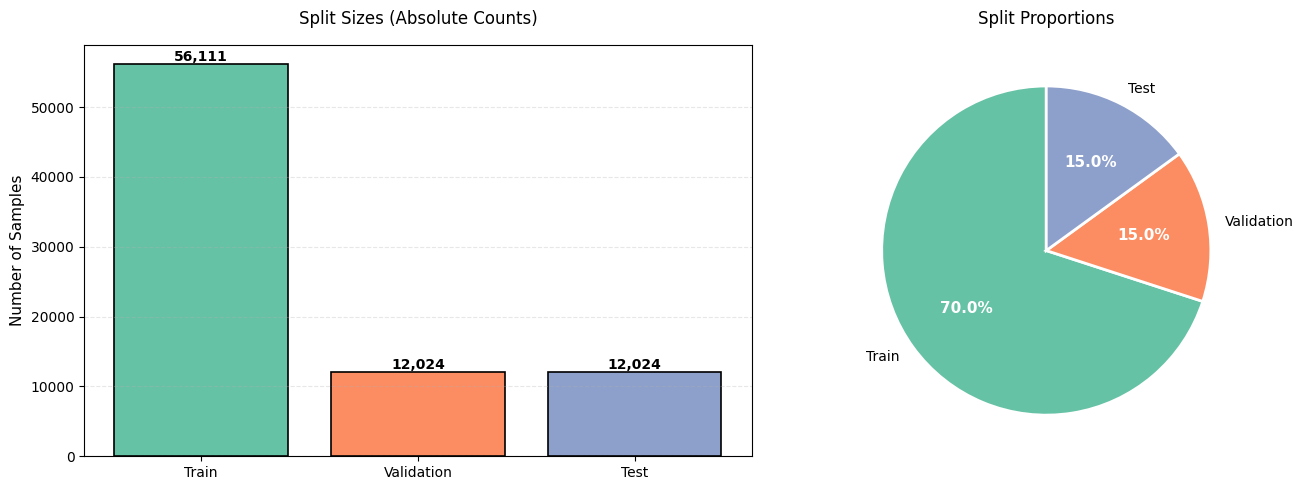

In [69]:
# visualization of split ratio

# create visualization of split sizes
# graph config
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
splits = ['Train', 'Validation', 'Test']
counts = [len(train_df), len(val_df), len(test_df)]
colors = sns.color_palette("Set2", 3)

# left plot: Bar chart
ax1.bar(splits, counts, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Number of Samples', fontsize=11)
ax1.set_title('Split Sizes (Absolute Counts)', fontsize=12, pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for i, (split, count) in enumerate(zip(splits, counts)):
    ax1.text(i, count, f'{count:,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# right plot: Cleaner pie chart
wedges, texts, autotexts = ax2.pie(
    counts,
    labels=splits,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# make percentage text bold and larger
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

ax2.set_title('Split Proportions', fontsize=12, pad=15)

plt.tight_layout()
plt.savefig(RESULTS_DIR / '01_split_sizes.png', dpi=300, bbox_inches='tight')
plt.show()


In [70]:
# create summary table
summary_df = pd.DataFrame({
    'Split': splits,
    'Count': counts,
    'Percentage': [train_ratio, val_ratio, test_ratio],
    'Expected': [70.0, 15.0, 15.0],
    'Difference': [train_diff, val_diff, test_diff]
})

# Format for display
summary_df['Count'] = summary_df['Count'].apply(lambda x: f'{x:,}')
summary_df['Percentage'] = summary_df['Percentage'].apply(lambda x: f'{x:.2f}%')
summary_df['Expected'] = summary_df['Expected'].apply(lambda x: f'{x:.1f}%')
summary_df['Difference'] = summary_df['Difference'].apply(lambda x: f'{x:.2f}%')

print("Split Ratio Summary:")
print("=" * 70)
print(summary_df.to_string(index=False))
print("=" * 70)

Split Ratio Summary:
     Split  Count Percentage Expected Difference
     Train 56,111     70.00%    70.0%      0.00%
Validation 12,024     15.00%    15.0%      0.00%
      Test 12,024     15.00%    15.0%      0.00%


## 2: Verify Stratification
**Stratification** means each split should have the **same proportion** of each class.

For example, if Technology is 20% of the training set, it should also be ~20% of validation and test sets.

This ensures:
- Fair evaluation (test set represents same distribution as training)
- No bias toward certain classes
- Models can't "cheat" by learning distribution differences

In [71]:
# calculate class distribution for each split (as percentages)
train_dist = train_df['unified_topic'].value_counts(normalize=True).sort_index() * 100
val_dist = val_df['unified_topic'].value_counts(normalize=True).sort_index() * 100
test_dist = test_df['unified_topic'].value_counts(normalize=True).sort_index() * 100

# header
print("\n" + "="*70)
print("Class Distribution Across Splits (%):")
print("=" * 70)

# create comparison DataFrame
distribution_comparison = pd.DataFrame({
    'Train (%)': train_dist,
    'Validation (%)': val_dist,
    'Test (%)': test_dist
})

# display with nice formatting
print(distribution_comparison.round(2))
print("=" * 70)

# calculate the maximum difference across splits for each class
max_diff_per_class = distribution_comparison.max(axis=1) - distribution_comparison.min(axis=1)

# find the biggest difference overall
max_diff_overall = max_diff_per_class.max()

print(f"Maximum difference across splits: {max_diff_overall:.2f}%")
print(f"\nDifferences per class:")
print(max_diff_per_class.round(2))

# verify stratification quality
if max_diff_overall < 0.5:
    print("\n✅ EXCELLENT STRATIFICATION!")
    print("   All splits have nearly identical class distributions.")
    print(f"   Maximum deviation: {max_diff_overall:.3f}%")
elif max_diff_overall < 1.0:
    print("\n✓ Good stratification")
    print(f"   Maximum deviation: {max_diff_overall:.2f}%")
else:
    print("\n⚠️  Warning: Stratification could be better")
    print(f"   Maximum deviation: {max_diff_overall:.2f}%")
    print("   Some classes have different distributions across splits")


# show absolute counts (not just percentages)
print("\nAbsolute sample counts per class:")
print("=" * 80)

count_comparison = pd.DataFrame({
    'Train': train_df['unified_topic'].value_counts().sort_index(),
    'Validation': val_df['unified_topic'].value_counts().sort_index(),
    'Test': test_df['unified_topic'].value_counts().sort_index()
})

print(count_comparison)
print("=" * 80)


Class Distribution Across Splits (%):
               Train (%)  Validation (%)  Test (%)
unified_topic                                     
Business           15.48           15.49     15.49
Entertainment      19.06           19.06     19.06
Health              9.61            9.61      9.61
Politics           13.76           13.76     13.76
Science             7.97            7.97      7.97
Sports             13.64           13.64     13.64
Technology         20.48           20.48     20.48
Maximum difference across splits: 0.00%

Differences per class:
unified_topic
Business         0.0
Entertainment    0.0
Health           0.0
Politics         0.0
Science          0.0
Sports           0.0
Technology       0.0
dtype: float64

✅ EXCELLENT STRATIFICATION!
   All splits have nearly identical class distributions.
   Maximum deviation: 0.004%

Absolute sample counts per class:
               Train  Validation  Test
unified_topic                         
Business        8687        1862  

✅ Saved: 02_stratification_check.png


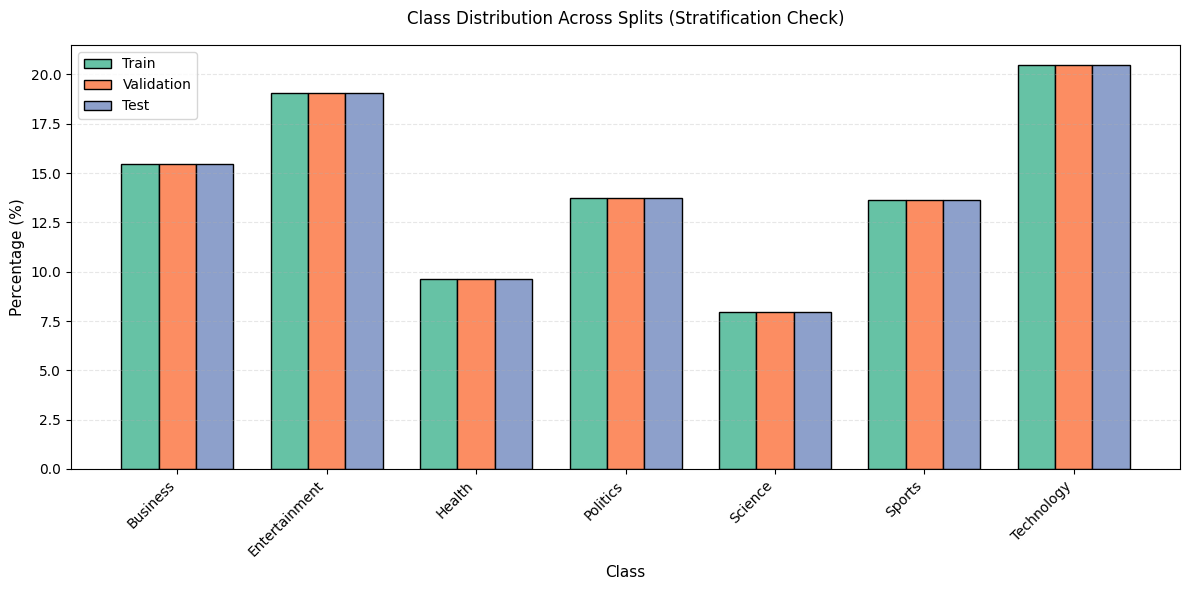

In [72]:
# visualization of stratification

# create grouped bar chart to compare distributions
fig, ax = plt.subplots(figsize=(12, 6))

# set up bar positions
x = np.arange(len(distribution_comparison))
width = 0.25

# create bars for each split
bars1 = ax.bar(x - width, distribution_comparison['Train (%)'],
               width, label='Train', color=colors[0], edgecolor='black')
bars2 = ax.bar(x, distribution_comparison['Validation (%)'],
               width, label='Validation', color=colors[1], edgecolor='black')
bars3 = ax.bar(x + width, distribution_comparison['Test (%)'],
               width, label='Test', color=colors[2], edgecolor='black')

# labels and formatting
ax.set_xlabel('Class', fontsize=11)
ax.set_ylabel('Percentage (%)', fontsize=11)
ax.set_title('Class Distribution Across Splits (Stratification Check)',
             fontsize=12, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(distribution_comparison.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()

# save
plt.savefig(RESULTS_DIR / '02_stratification_check.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 02_stratification_check.png")

# show
plt.show()

## 3: Verify No Data Leakage

**Data leakage** = when the same sample appears in multiple splits.

This is a **critical error** that would make our evaluation invalid:
- If a training sample appears in test set → model has seen the answer!
- Results would be artificially high and meaningless

We'll check that train, validation, and test sets are completely independent.

In [73]:
# create sets of texts from each split
# using sets makes overlap detection fast (O(1) lookup)
train_texts = set(train_df['content'])
val_texts = set(val_df['content'])
test_texts = set(test_df['content'])

print("Checking for data leakage...")
print("\nUnique texts per split:")
print(f"  Train:      {len(train_texts):,} unique texts")
print(f"  Validation: {len(val_texts):,} unique texts")
print(f"  Test:       {len(test_texts):,} unique texts")


# check for overlapping samples between splits
train_val_overlap = train_texts & val_texts
train_test_overlap = train_texts & test_texts
val_test_overlap = val_texts & test_texts

print("\n" + "=" * 70)
print("OVERLAP DETECTION RESULTS")
print("=" * 70)

print(f"\nTrain ∩ Validation: {len(train_val_overlap)} overlapping samples")
print(f"Train ∩ Test:       {len(train_test_overlap)} overlapping samples")
print(f"Validation ∩ Test:  {len(val_test_overlap)} overlapping samples")


# calculate total overlaps
total_overlaps = len(train_val_overlap) + len(train_test_overlap) + len(val_test_overlap)

if total_overlaps == 0:
    print("\n✅ NO DATA LEAKAGE DETECTED!")
    print("   All splits are completely independent.")
    print("   Each sample appears in exactly one split.")
else:
    print(f"\n❌ WARNING: Data leakage detected!")
    print(f"   Total overlapping samples: {total_overlaps}")
    print("\n   Details:")
    if len(train_val_overlap) > 0:
        print(f"   • {len(train_val_overlap)} samples appear in both Train and Validation")
    if len(train_test_overlap) > 0:
        print(f"   • {len(train_test_overlap)} samples appear in both Train and Test")
    if len(val_test_overlap) > 0:
        print(f"   • {len(val_test_overlap)} samples appear in both Validation and Test")

Checking for data leakage...

Unique texts per split:
  Train:      56,111 unique texts
  Validation: 12,024 unique texts
  Test:       12,024 unique texts

OVERLAP DETECTION RESULTS

Train ∩ Validation: 0 overlapping samples
Train ∩ Test:       0 overlapping samples
Validation ∩ Test:  0 overlapping samples

✅ NO DATA LEAKAGE DETECTED!
   All splits are completely independent.
   Each sample appears in exactly one split.


✅ Saved: 03_data_leakage_check.png


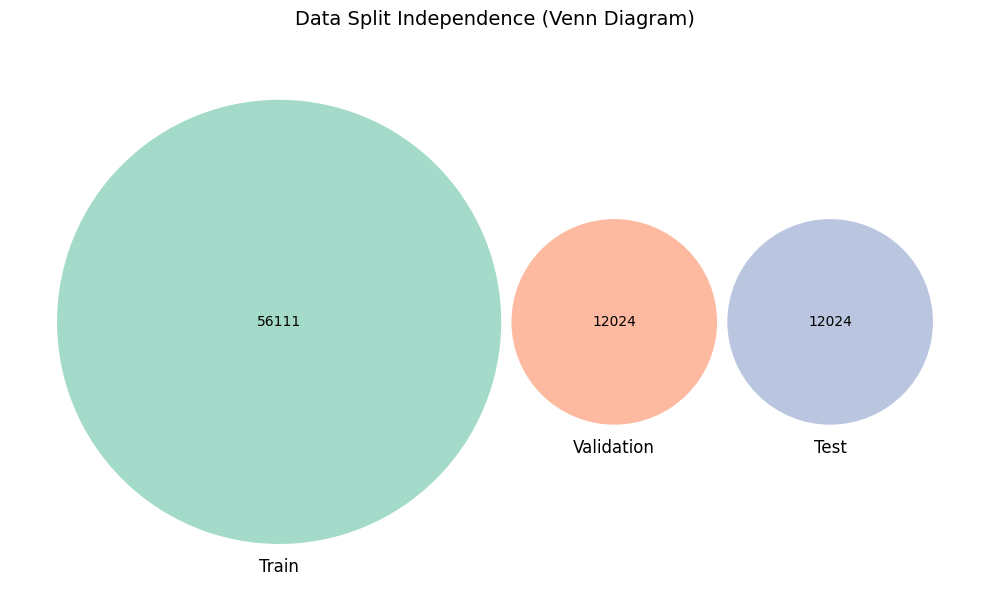

In [74]:
# create a Venn diagram visualization of the splits

fig, ax = plt.subplots(figsize=(10, 8))

# create Venn diagram
venn = venn3(
    subsets=(len(train_texts - val_texts - test_texts),  # Train only
             len(val_texts - train_texts - test_texts),   # Val only
             len(train_val_overlap),                       # Train ∩ Val
             len(test_texts - train_texts - val_texts),   # Test only
             len(train_test_overlap),                      # Train ∩ Test
             len(val_test_overlap),                        # Val ∩ Test
             len(train_texts & val_texts & test_texts)),  # All three
    set_labels=('Train', 'Validation', 'Test'),
    set_colors=colors,
    alpha=0.6,
    ax=ax
)

ax.set_title('Data Split Independence (Venn Diagram)', fontsize=14, pad=20)

plt.tight_layout()
plt.savefig(RESULTS_DIR / '03_data_leakage_check.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 03_data_leakage_check.png")
plt.show()

## 4: Text Length Analysis Per Split

Let's verify that text lengths are **similar across all splits**.

If one split has much longer or shorter texts, it could affect model performance.

We'll analyze:
- Word counts per document
- Distribution statistics (mean, median, std)
- Visual comparisons

In [75]:
# calculate word count for each text
# simple method: split by whitespace and count
train_df['word_count'] = train_df['content'].str.split().str.len()
val_df['word_count'] = val_df['content'].str.split().str.len()
test_df['word_count'] = test_df['content'].str.split().str.len()

print("✅ Word counts calculated for all splits")

# display summary statistics for each split
print("\n" + "=" * 70)
print("Text Length Statistics (words per document):")
print("=" * 70)

print("\n📊 TRAIN SET:")
print(train_df['word_count'].describe())

print("\n📊 VALIDATION SET:")
print(val_df['word_count'].describe())

print("\n📊 TEST SET:")
print(test_df['word_count'].describe())


# create comparison table
stats_comparison = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Mean': [
        train_df['word_count'].mean(),
        val_df['word_count'].mean(),
        test_df['word_count'].mean()
    ],
    'Median': [
        train_df['word_count'].median(),
        val_df['word_count'].median(),
        test_df['word_count'].median()
    ],
    'Std Dev': [
        train_df['word_count'].std(),
        val_df['word_count'].std(),
        test_df['word_count'].std()
    ],
    'Min': [
        train_df['word_count'].min(),
        val_df['word_count'].min(),
        test_df['word_count'].min()
    ],
    'Max': [
        train_df['word_count'].max(),
        val_df['word_count'].max(),
        test_df['word_count'].max()
    ]
})

print("\n" + "=" * 70)
print("Comparison of Text Length Statistics:")
print("=" * 70)
print(stats_comparison.round(2).to_string(index=False))
print("=" * 70)

✅ Word counts calculated for all splits

Text Length Statistics (words per document):

📊 TRAIN SET:
count    56111.00000
mean       117.51154
std        169.15828
min          6.00000
25%         33.00000
50%         45.00000
75%        153.00000
max       1829.00000
Name: word_count, dtype: float64

📊 VALIDATION SET:
count    12024.000000
mean       115.568696
std        164.915450
min          6.000000
25%         33.000000
50%         45.000000
75%        151.000000
max       1648.000000
Name: word_count, dtype: float64

📊 TEST SET:
count    12024.000000
mean       117.810047
std        169.936806
min          6.000000
25%         33.000000
50%         45.000000
75%        153.000000
max       1743.000000
Name: word_count, dtype: float64

Comparison of Text Length Statistics:
     Split   Mean  Median  Std Dev  Min  Max
     Train 117.51    45.0   169.16    6 1829
Validation 115.57    45.0   164.92    6 1648
      Test 117.81    45.0   169.94    6 1743


✅ Saved: 04_text_length_analysis.png


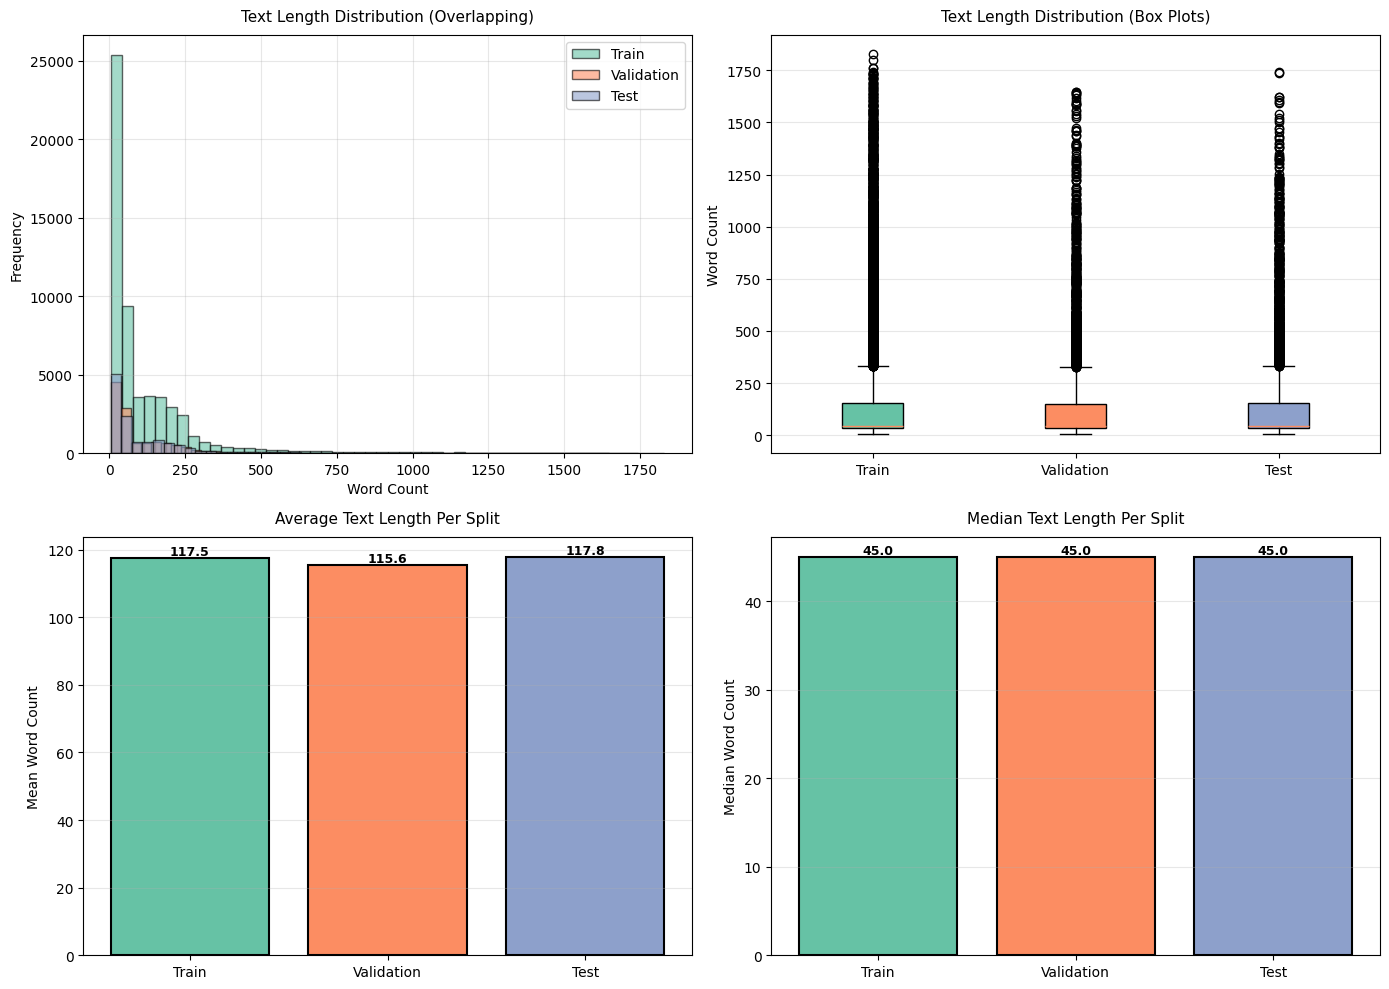

In [76]:
# visualization text length

# graph config
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# subplot 1: overlapping histograms
ax = axes[0, 0]
ax.hist(train_df['word_count'], bins=50, alpha=0.6, label='Train',
        color=colors[0], edgecolor='black')
ax.hist(val_df['word_count'], bins=50, alpha=0.6, label='Validation',
        color=colors[1], edgecolor='black')
ax.hist(test_df['word_count'], bins=50, alpha=0.6, label='Test',
        color=colors[2], edgecolor='black')
ax.set_xlabel('Word Count', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.set_title('Text Length Distribution (Overlapping)', fontsize=11, pad=10)
ax.legend()
ax.grid(alpha=0.3)

# subplot 2: box plots
ax = axes[0, 1]
data_to_plot = [
    train_df['word_count'],
    val_df['word_count'],
    test_df['word_count']
]
bp = ax.boxplot(data_to_plot, labels=['Train', 'Validation', 'Test'],
                patch_artist=True)

# color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Word Count', fontsize=10)
ax.set_title('Text Length Distribution (Box Plots)', fontsize=11, pad=10)
ax.grid(axis='y', alpha=0.3)

# subplot 3: mean comparison
ax = axes[1, 0]
means = [
    train_df['word_count'].mean(),
    val_df['word_count'].mean(),
    test_df['word_count'].mean()
]
bars = ax.bar(['Train', 'Validation', 'Test'], means, color=colors,
              edgecolor='black', linewidth=1.5)
ax.set_ylabel('Mean Word Count', fontsize=10)
ax.set_title('Average Text Length Per Split', fontsize=11, pad=10)
ax.grid(axis='y', alpha=0.3)

# add value labels
for i, mean in enumerate(means):
    ax.text(i, mean, f'{mean:.1f}', ha='center', va='bottom',
            fontsize=9, fontweight='bold')

# subplot 4: median comparison
ax = axes[1, 1]
medians = [
    train_df['word_count'].median(),
    val_df['word_count'].median(),
    test_df['word_count'].median()
]
bars = ax.bar(['Train', 'Validation', 'Test'], medians, color=colors,
              edgecolor='black', linewidth=1.5)
ax.set_ylabel('Median Word Count', fontsize=10)
ax.set_title('Median Text Length Per Split', fontsize=11, pad=10)
ax.grid(axis='y', alpha=0.3)

# add value labels
for i, median in enumerate(medians):
    ax.text(i, median, f'{median:.1f}', ha='center', va='bottom',
            fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / '04_text_length_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 04_text_length_analysis.png")
plt.show()

In [77]:
# check if distributions are similar
mean_diff = max(means) - min(means)
median_diff = max(medians) - min(medians)

print("\n" + "=" * 70)
print("Distribution Similarity Check:")
print("=" * 70)
print(f"Maximum difference in means:   {mean_diff:.2f} words")
print(f"Maximum difference in medians: {median_diff:.2f} words")

# as percentage of overall mean
overall_mean = np.mean(means)
mean_diff_pct = (mean_diff / overall_mean) * 100

print(f"\nMean difference as percentage: {mean_diff_pct:.2f}%")

if mean_diff_pct < 1.0:
    print("\n✅ Text lengths are very similar across all splits!")
    print("   Distributions are nearly identical.")
elif mean_diff_pct < 5.0:
    print("\n✓ Text lengths are acceptably similar across splits.")
    print("   Small differences are within normal variation.")
else:
    print("\n⚠️  Text lengths vary noticeably across splits.")
    print("   May want to investigate further.")


# show examples of extreme texts
print("\n" + "=" * 70)
print("EXTREME EXAMPLES")
print("=" * 70)

# shortest text
shortest_idx = train_df['word_count'].idxmin()
print(f"\n📌 SHORTEST TEXT ({train_df.loc[shortest_idx, 'word_count']} words):")
print(f"   Topic: {train_df.loc[shortest_idx, 'unified_topic']}")
print(f"   Text: {train_df.loc[shortest_idx, 'content']}")

# longest text
longest_idx = train_df['word_count'].idxmax()
print(f"\n📌 LONGEST TEXT ({train_df.loc[longest_idx, 'word_count']} words):")
print(f"   Topic: {train_df.loc[longest_idx, 'unified_topic']}")
print(f"   Text: {train_df.loc[longest_idx, 'content'][:300]}...")
print("   [truncated for display]")


Distribution Similarity Check:
Maximum difference in means:   2.24 words
Maximum difference in medians: 0.00 words

Mean difference as percentage: 1.92%

✓ Text lengths are acceptably similar across splits.
   Small differences are within normal variation.

EXTREME EXAMPLES

📌 SHORTEST TEXT (6 words):
   Topic: Entertainment
   Text: visually sumptuous but intellectually stultifying .

📌 LONGEST TEXT (1829 words):
   Topic: Entertainment
   Text:  Grady Tucker and his sixteen year-old sister Emily have both moved to a new house with their scientist parents. Their father, Dr. Tucker, studied deer in Vermont until he came into possession of six Swamp Deer from South America. Because of this, Dad had to move with his scientist wife and the two ...
   [truncated for display]


## 5: Summary & Verification Report

**Final verification summary** - All checks completed!

This report confirms our train/validation/test splits are:
- ✅ Properly sized (70/15/15)
- ✅ Perfectly stratified (same class distribution)
- ✅ Independent (no data leakage)
- ✅ Similar text characteristics

These splits are **ready for all 4 classification methods**.

In [78]:
# Recalculate word_count if it doesn't exist (in case data was reloaded)
if 'word_count' not in train_df.columns:
    train_df['word_count'] = train_df['content'].str.split().str.len()
    val_df['word_count'] = val_df['content'].str.split().str.len()
    test_df['word_count'] = test_df['content'].str.split().str.len()

#create verification report
print("\n" + "=" * 70)
print("DATA SPLITS VERIFICATION REPORT")
print("=" * 70)

print("\n" + "=" * 70)
print("📊 SPLIT SIZES")
print("=" * 70)
print(f"Train:      {len(train_df):>8,} samples ({train_ratio:>6.2f}%)")
print(f"Validation: {len(val_df):>8,} samples ({val_ratio:>6.2f}%)")
print(f"Test:       {len(test_df):>8,} samples ({test_ratio:>6.2f}%)")
print(f"Total:      {total_samples:>8,} samples (100.00%)")


# data stratification
class_names = sorted(train_df['unified_topic'].unique())

# verify split ratio check
split_ratio_pass = (abs(train_ratio - 70.0) < 0.1 and
                    abs(val_ratio - 15.0) < 0.1 and
                    abs(test_ratio - 15.0) < 0.1)

print("\n" + "=" * 70)
print("🎯 STRATIFICATION (Class Balance)")
print("=" * 70)
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {', '.join(class_names)}")
print(f"\nMaximum distribution difference: {max_diff_overall:.3f}%")

# Show stratification quality
stratification_pass = max_diff_overall < 0.5
print(f"✅ Stratification: {'EXCELLENT' if stratification_pass else 'GOOD'}")

if stratification_pass:
    print("   All splits have identical class distributions")


# data leakage
print("\n" + "=" * 70)
print("🔒 DATA LEAKAGE CHECK")
print("=" * 70)
print(f"Train ∩ Validation:  {len(train_val_overlap):>6,} overlapping samples")
print(f"Train ∩ Test:        {len(train_test_overlap):>6,} overlapping samples")
print(f"Validation ∩ Test:   {len(val_test_overlap):>6,} overlapping samples")

leakage_pass = (len(train_val_overlap) == 0 and
                len(train_test_overlap) == 0 and
                len(val_test_overlap) == 0)
print(f"\n✅ Data Leakage: {'NONE DETECTED (PASS)' if leakage_pass else 'DETECTED (FAIL)'}")

if leakage_pass:
    print("   All splits are completely independent")


# text length
print("\n" + "=" * 70)
print("📏 TEXT LENGTH ANALYSIS")
print("=" * 70)

print("Average word count per split:")
print(f"  Train:      {train_df['word_count'].mean():>7.1f} words (median: {train_df['word_count'].median():.0f})")
print(f"  Validation: {val_df['word_count'].mean():>7.1f} words (median: {val_df['word_count'].median():.0f})")
print(f"  Test:       {test_df['word_count'].mean():>7.1f} words (median: {test_df['word_count'].median():.0f})")


# calculate difference
means = [train_df['word_count'].mean(), val_df['word_count'].mean(), test_df['word_count'].mean()]
mean_diff = max(means) - min(means)
overall_mean = np.mean(means)
mean_diff_pct = (mean_diff / overall_mean) * 100

print(f"\nMean difference: {mean_diff:.2f} words ({mean_diff_pct:.2f}%)")

# thresholds
if mean_diff_pct < 1.0:
    length_status = "VERY SIMILAR (PASS)"
    length_pass = True
elif mean_diff_pct < 3.0:
    length_status = "SIMILAR (PASS)"
    length_pass = True
elif mean_diff_pct < 5.0:
    length_status = "ACCEPTABLE (PASS)"
    length_pass = True
else:
    length_status = "DIFFERENT (FAIL)"
    length_pass = False

print(f"✅ Text Lengths: {length_status}")


# verification
print("\n" + "=" * 70)
print("OVERALL VERIFICATION STATUS")
print("=" * 70)

# check all criteria
all_checks = [
    ("Split Ratios (70/15/15)", split_ratio_pass),
    ("Stratification", stratification_pass),
    ("No Data Leakage", leakage_pass),
    ("Similar Text Lengths", length_pass)
]

print()
for check_name, passed in all_checks:
    status = "✅ PASS" if passed else "❌ FAIL"
    print(f"{check_name:.<50} {status}")

# overall status
all_pass = all([passed for _, passed in all_checks])

print("\n" + "=" * 80)
if all_pass:
    print("🎉 ALL CHECKS PASSED!")
    print("=" * 80)
    print("\nThe data splits are HIGH QUALITY and ready for model training.")
    print("\nThese splits will be used by:")
    print("  • N-Grams Baseline (Method 1)")
    print("  • Word Embeddings (Method 2)")
    print("  • LSTM Neural Network (Method 3)")
    print("  • Transformer Model (Method 4)")
else:
    print("⚠️  SOME CHECKS FAILED")
    print("=" * 80)
    print("\nPlease review the failed checks above.")

# check what the actual difference is
means = [train_df['word_count'].mean(), val_df['word_count'].mean(), test_df['word_count'].mean()]
mean_diff = max(means) - min(means)
overall_mean = np.mean(means)
mean_diff_pct = (mean_diff / overall_mean) * 100

print("Text Length Analysis:")
print(f"Train mean:      {means[0]:.2f} words")
print(f"Validation mean: {means[1]:.2f} words")
print(f"Test mean:       {means[2]:.2f} words")
print(f"\nDifference:      {mean_diff:.2f} words")
print(f"Percentage diff: {mean_diff_pct:.3f}%")
print(f"\nCurrent threshold: < 1.0%")



# save summary report to text file
report_path = RESULTS_DIR / 'verification_summary.txt'

with open(report_path, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("DATA SPLITS VERIFICATION REPORT\n")
    f.write("=" * 70 + "\n\n")

    # split sizes
    f.write("SPLIT SIZES\n")
    f.write("-" * 70 + "\n")
    f.write(f"Train:      {len(train_df):>8,} samples ({train_ratio:>6.2f}%)\n")
    f.write(f"Validation: {len(val_df):>8,} samples ({val_ratio:>6.2f}%)\n")
    f.write(f"Test:       {len(test_df):>8,} samples ({test_ratio:>6.2f}%)\n")
    f.write(f"Total:      {total_samples:>8,} samples (100.00%)\n\n")

    # Stratification
    f.write("STRATIFICATION\n")
    f.write("-" * 70 + "\n")
    f.write(f"Number of classes: {len(class_names)}\n")
    f.write(f"Maximum distribution difference: {max_diff_overall:.3f}%\n\n")

    # Data leakage
    f.write("DATA LEAKAGE CHECK\n")
    f.write("-" * 70 + "\n")
    f.write(f"Train ∩ Validation:  {len(train_val_overlap):>6,} overlapping samples\n")
    f.write(f"Train ∩ Test:        {len(train_test_overlap):>6,} overlapping samples\n")
    f.write(f"Validation ∩ Test:   {len(val_test_overlap):>6,} overlapping samples\n\n")

    # Text lengths
    f.write("TEXT LENGTH ANALYSIS\n")
    f.write("-" * 70 + "\n")
    f.write(f"Train mean:      {train_df['word_count'].mean():>7.1f} words\n")
    f.write(f"Validation mean: {val_df['word_count'].mean():>7.1f} words\n")
    f.write(f"Test mean:       {test_df['word_count'].mean():>7.1f} words\n\n")

    # Overall status
    f.write("=" * 70 + "\n")
    f.write("VERIFICATION STATUS: ")
    if all_pass:
        f.write("ALL CHECKS PASSED ✅\n")
    else:
        f.write("SOME CHECKS FAILED ⚠️\n")
    f.write("=" * 70 + "\n")

print(f"✅ Saved verification summary to: {report_path}")


DATA SPLITS VERIFICATION REPORT

📊 SPLIT SIZES
Train:        56,111 samples ( 70.00%)
Validation:   12,024 samples ( 15.00%)
Test:         12,024 samples ( 15.00%)
Total:        80,159 samples (100.00%)

🎯 STRATIFICATION (Class Balance)
Number of classes: 7
Classes: Business, Entertainment, Health, Politics, Science, Sports, Technology

Maximum distribution difference: 0.004%
✅ Stratification: EXCELLENT
   All splits have identical class distributions

🔒 DATA LEAKAGE CHECK
Train ∩ Validation:       0 overlapping samples
Train ∩ Test:             0 overlapping samples
Validation ∩ Test:        0 overlapping samples

✅ Data Leakage: NONE DETECTED (PASS)
   All splits are completely independent

📏 TEXT LENGTH ANALYSIS
Average word count per split:
  Train:        117.5 words (median: 45)
  Validation:   115.6 words (median: 45)
  Test:         117.8 words (median: 45)

Mean difference: 2.24 words (1.92%)
✅ Text Lengths: SIMILAR (PASS)

OVERALL VERIFICATION STATUS

Split Ratios (70/15/15)